# Test marineheatwaves pkg to understand how changing to ordinal date interacts with noleap calendar

Test how much drift the conversion into ordinal numbers creates when starting with a time vector that uses a model, noleap calendar using the standard marineheatwaves algorithm where day of year manual calculated and expects a standard gregorian calendar.

**Take away:** For a 100 year slice of model data, the algorithm ends up assigning day of year values with
a spread of 24 days to a single model day of year value. 😒👎

In [1]:
# Import some useful packages
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np
from datetime import date
import cftime
import matplotlib.pyplot as plt
import cmocean

# Import the marineHeatWaves package
import marineHeatWaves as mhw

## Set read and write paths

In [2]:
# path to all post-processed (pp) data
rootdir = ('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'+
           'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/'+
           'pp/')
# specific pp directory
ppname = 'ocean_daily_1x1deg'
# local directory
localdir = '/ts/daily/5yr/'
# Now specify the name of the file you want to open
# NOTE that the filenames always start with the same ppname,
# so I can save some hassle here...
# Use wildcards to grab the years 101 - 200
filename = ppname +'.01[0123456789][16]0101-0[12][0123456789][50]1231.tos.nc'

In [3]:
# The combination of all these defines the path
path = rootdir+ppname+localdir+filename

## Import data

In [4]:
# Load the file using xarray
# For memory reasons, we are going to "chunk" the data in the time dimension
ds = xr.open_mfdataset(path,use_cftime=True,combine='by_coords',engine='netcdf4',
                       drop_variables=['average_DT', 'average_T1', 'average_T2']).chunk({'time':365})

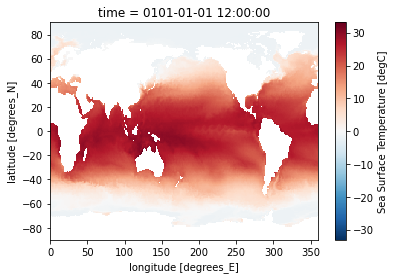

In [5]:
ds['tos'].isel(time=0).plot()
plt.show()

### Subset data
Select a single latitude and longitude (note that we are doing this with the "nominal" coordinate here, so it is not 100% accurate for that location (see discussion in the plotting geodata tutorial). However, it is good enough for our purposes.  

We will also load/compute the data into memory here, which may take several minutes.

In [6]:
# Pick a spot in the Atlantic, on the equator
tos = ds['tos'].sel(lon=165,lat=-5,method='nearest')
with ProgressBar():
    tos = tos.compute()

[########################################] | 100% Completed | 18.1s


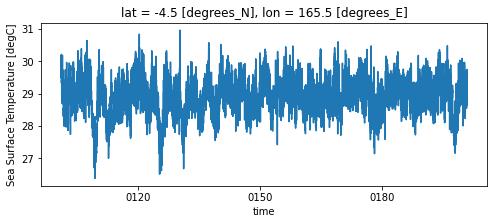

In [7]:
# Quick check of what the time-series looks like
tos.plot(figsize=(8,3))
plt.show()

### Dealing with the time variables
The marineHeatWaves package is set up to accept "ordinal" dates from the Gregorian calendar. That is, January 1 of year 0001 has ordinal date 1, January 2 of year 0002 has ordinal date 2, and so on.  

The model data that we are working with uses a NoLeapYear calendar, which we can convert to ordinal days using the `cftime` package. It is worth noting that this means there is a mismatch between our handling of the time array, and the way that marineHeatWaves handles the time array (where the latter assumes that the ordinal time corresponds to a standard Gregorian Calendar).

In [8]:
# Create an array of ordinal times
otimes = cftime.date2num(ds['time'].values,units='days since 0001-01-01-12:00:00',calendar='noleap')

## Set variables to expected names

In [9]:
# Time
t = otimes

In [10]:
# Temperature
temp = tos.values

## Start testing pkg code

### Set defaults

In [11]:
climatologyPeriod=[None,None]
pctile=90
windowHalfWidth=5
smoothPercentile=True
smoothPercentileWidth=31
minDuration=5
joinAcrossGaps=True
maxGap=2
maxPadLength=False
coldSpells=False
alternateClimatology=False
Ly=False

### Time and dates vectors

In [12]:
# Generate vectors for year, month, day-of-month, and day-of-year
T = len(t)
year = np.zeros((T))
month = np.zeros((T))
day = np.zeros((T))
doy = np.zeros((T))
for i in range(T):
    year[i] = date.fromordinal(t[i]).year
    month[i] = date.fromordinal(t[i]).month
    day[i] = date.fromordinal(t[i]).day

In [13]:
# Leap-year baseline for defining day-of-year values
year_leapYear = 2012 # This year was a leap-year and therefore doy in range of 1 to 366
t_leapYear = np.arange(date(year_leapYear, 1, 1).toordinal(),date(year_leapYear, 12, 31).toordinal()+1)
dates_leapYear = [date.fromordinal(tt.astype(int)) for tt in t_leapYear]
month_leapYear = np.zeros((len(t_leapYear)))
day_leapYear = np.zeros((len(t_leapYear)))
doy_leapYear = np.zeros((len(t_leapYear)))
for tt in range(len(t_leapYear)):
    month_leapYear[tt] = date.fromordinal(t_leapYear[tt]).month
    day_leapYear[tt] = date.fromordinal(t_leapYear[tt]).day
    doy_leapYear[tt] = t_leapYear[tt] - date(date.fromordinal(t_leapYear[tt]).year,1,1).toordinal() + 1

In [14]:
# Calculate day-of-year values
for tt in range(T):
    doy[tt] = doy_leapYear[(month_leapYear == month[tt]) * (day_leapYear == day[tt])]

## Test spread in algorithm day of year compared to actual day of year

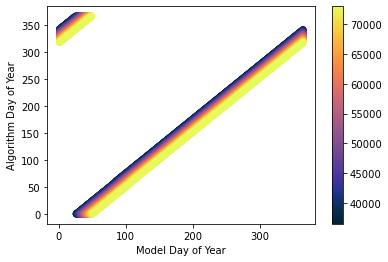

In [15]:
plt.scatter(ds['time'].dt.dayofyear,doy,c=t,cmap='cmo.thermal')
plt.xlabel('Model Day of Year')
plt.ylabel('Algorithm Day of Year')
plt.colorbar()
plt.show()

In [16]:
test = ds['time'].dt.dayofyear[np.where(doy==1)]

In [17]:
print('The algorithm ends up assigning day of year values with')
print('a spread of %i days to a single model day of year value.' % (test.max() - test.min()).values)

The algorithm ends up assigning day of year values with
a spread of 24 days to a single model day of year value.
